The purpose of this workbook is to perform a statistical analysis of receiving yards based on yards to go for first down. We will use a linear regression model to calculate expected receiving yards and compare those to actual yards accounted for. Finally, we will look for a year-over-year correlation between receiving stats.

In [1]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import pbp data
seasons = range(2016, 2022 + 1)
pbp = nfl.import_pbp_data(seasons)

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


In [5]:
# Filter on receiving data
pbp_rec = pbp.query('play_type == "pass" & receiver_id.notnull()').reset_index()

pbp_rec.loc[pbp_rec.receiving_yards.isnull(), 'receiving_yards'] = 0

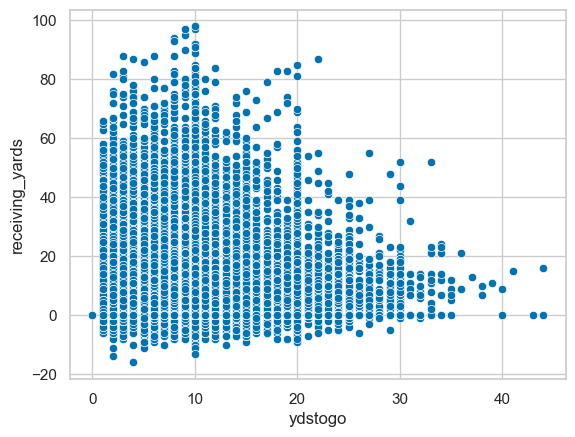

In [6]:
# Plot the raw data prior to building a model
sns.set_theme(style='whitegrid', palette='colorblind')
sns.scatterplot(data=pbp_rec, x='ydstogo', y='receiving_yards');

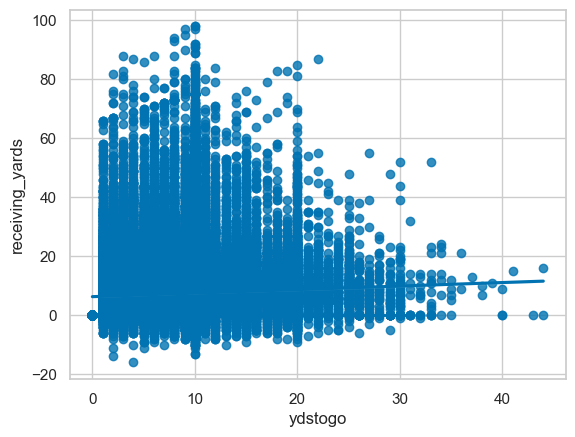

In [7]:
# Replot the data with a trend line
sns.regplot(data=pbp_rec, x='ydstogo', y='receiving_yards');

In [8]:
# Average over each yards per reception value in each ydstogo bin
pbp_rec_avg = pbp_rec.groupby('ydstogo').agg({'receiving_yards': ['mean']})

pbp_rec_avg.columns = list(map('_'.join, pbp_rec_avg.columns))

pbp_rec_avg.reset_index(inplace=True)

pbp_rec_avg.head()

,ydstogo,receiving_yards_mean
0,0.0,0.000000
1,1.0,6.069597
2,2.0,6.453876
3,3.0,6.295941
4,4.0,6.524111


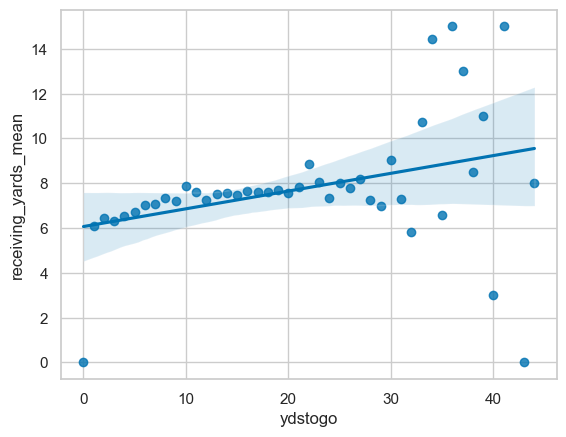

In [9]:
# Plot avg receiving yards by ydstogo
sns.regplot(data=pbp_rec_avg, x='ydstogo', y='receiving_yards_mean');

<b>Linear Regression Model

In [10]:
# Model the data and save it to a variable
yds_to_go = smf.ols(formula='receiving_yards ~ 1 + ydstogo', data=pbp_rec)

In [11]:
# Fit the model and print the summary
print(yds_to_go.fit().summary())

                            OLS Regression Results                            
Dep. Variable:        receiving_yards   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     318.2
Date:                Sun, 07 Jan 2024   Prob (F-statistic):           4.28e-71
Time:                        11:08:22   Log-Likelihood:            -4.7466e+05
No. Observations:              128604   AIC:                         9.493e+05
Df Residuals:                  128602   BIC:                         9.493e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.2968      0.065     96.411      0.0

In [12]:
# Create a new RYOE (Receiving Yards Over Expected) column in the data frame
pbp_rec['ryoe'] = yds_to_go.fit().resid

<b>Analyze RYOE

In [14]:
# Create a new RYOE data frame that is easier to work with
ryoe_df = (pbp_rec.groupby(['season', 'receiver_id', 'receiver'])
            .agg({'ryoe': ['count', 'sum', 'mean'], 
                  'receiving_yards': 'mean'}))

In [15]:
ryoe_df.columns = list(map('_'.join, ryoe_df.columns))

ryoe_df.reset_index(inplace=True)

In [17]:
ryoe_df = (ryoe_df.rename(columns={
            'ryoe_count': 'n',
            'ryoe_sum': 'ryoe_total',
            'ryoe_mean': 'ryoe_per',
            'receiving_yards_mean': 'yards_per_catch'
        }).query('n > 50'))

In [23]:
ryoe_df.sort_values(by='ryoe_total', ascending=False).reset_index(drop=True)

,season,receiver_id,receiver,n,ryoe_total,ryoe_per,yards_per_catch
0,2021,00-0033908,C.Kupp,234,715.053803,3.055785,10.363248
1,2021,00-0036900,J.Chase,163,627.542687,3.849955,11.184049
2,2016,00-0027944,J.Jones,154,599.663735,3.893920,11.318182
3,2021,00-0035719,D.Samuel,135,549.695089,4.071815,11.488889
4,2018,00-0032211,T.Lockett,77,517.762364,6.724187,14.090909
...,...,...,...,...,...,...,...
952,2022,00-0033699,A.Ekeler,131,-255.687176,-1.951811,5.465649
953,2016,00-0030525,T.Austin,106,-274.133714,-2.586167,4.801887
954,2021,00-0032688,R.Anderson,110,-294.948881,-2.681353,4.718182
955,2017,00-0031045,C.Hyde,88,-306.499649,-3.482951,3.977273


<b>Is RYOE a consistent metric?

In [25]:
# Keep only the columns we need
cols_keep = ['season', 'receiver_id', 'receiver', 'ryoe_per', 'yards_per_catch']

# Create current data frame
ryoe_now = ryoe_df[cols_keep].copy()

# Create last year's data frame
ryoe_last = ryoe_df[cols_keep].copy()

In [26]:
# Rename columns
ryoe_last.rename(columns={'ryoe_per': 'ryoe_per_last', 'yards_per_catch': 'yards_per_catch_last'}, inplace=True)

In [27]:
# Add 1 to season
ryoe_last['season'] += 1

In [28]:
# Merge together into new data frame
ryoe_lag = ryoe_now.merge(ryoe_last, how='inner', on=['receiver_id', 'receiver', 'season'])

In [29]:
# Examine the correlation for yards per catch
ryoe_lag[['yards_per_catch_last', 'yards_per_catch']].corr()

,yards_per_catch_last,yards_per_catch
yards_per_catch_last,1.000000,0.391837
yards_per_catch,0.391837,1.000000


In [30]:
# Examine the correlation for RYOE
ryoe_lag[['ryoe_per_last', 'ryoe_per']].corr()

,ryoe_per_last,ryoe_per
ryoe_per_last,1.00000,0.40301
ryoe_per,0.40301,1.00000


There exists a sligthly stronger correlation of year-over-year RYOE compared to year-over-year yards per catch